In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
# from preprocessing.UTKFaces_preprocesing import load_data, resample_data,split_data,data_loader
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [3]:
def load_data():
    image_directory = '/kaggle/input/utkface-new/UTKFace'
    image_files = os.listdir(image_directory)

    age_labels = []
    gender_labels = []
    image_paths = []

    for file in image_files:
        parts = file.split('_')
        age = int(parts[0])
        gender = int(parts[1])
        age_labels.append(age)
        gender_labels.append(gender)
        image_paths.append(os.path.join(image_directory, file))

    # Create a DataFrame for easy manipulation
    df = pd.DataFrame({
        'image_path': image_paths,
        'age': age_labels,
        'gender': gender_labels
    })
    
    bins = np.linspace(0, 116, 16).astype(int).tolist()
    labels = list(range(15)) 
    df['Age_Group'] = pd.cut(df['age'], bins=bins, labels=labels)# Check dataset structure
    return df


def resample_data(df):

    target_samples_per_group = 1000
    balanced_dfs = []

    # Loop through each age group and adjust to have exactly 1,000 samples
    for i in range(15):
        df_group = df[df['Age_Group'] == i]
        if len(df_group) > target_samples_per_group:
            df_group = resample(df_group, replace=False, n_samples=target_samples_per_group, random_state=42)
        elif len(df_group) < target_samples_per_group:
            df_group = resample(df_group, replace=True, n_samples=target_samples_per_group, random_state=42)
        balanced_dfs.append(df_group)

    # Concatenate and shuffle the balanced dataframes
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df



def split_data(df):
    # train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    return train_df, val_df, test_df

def data_loader(df,batch_size=32,shuffle=True):
    loader = DataLoader(df, batch_size=batch_size, shuffle=shuffle)
    return loader

from torch.utils.data import DataLoader, Dataset
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['Age_Group']
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label)
        return image, label


=================== EPOCH 1 ====================
Validation:
Accuracy: 14.80%, Avg loss: 2.5170
=================== EPOCH 2 ====================
Validation:
Accuracy: 26.67%, Avg loss: 2.0893
=================== EPOCH 3 ====================
Validation:
Accuracy: 36.18%, Avg loss: 1.7235
=================== EPOCH 4 ====================
Validation:
Accuracy: 39.78%, Avg loss: 1.5906
=================== EPOCH 5 ====================
Validation:
Accuracy: 44.49%, Avg loss: 1.4649
=================== EPOCH 6 ====================
Validation:
Accuracy: 48.36%, Avg loss: 1.3024
=================== EPOCH 7 ====================
Validation:
Accuracy: 50.58%, Avg loss: 1.2598
=================== EPOCH 8 ====================
Validation:
Accuracy: 50.84%, Avg loss: 1.2397
=================== EPOCH 9 ====================
Validation:
Accuracy: 52.89%, Avg loss: 1.2089
=================== EPOCH 10 ====================
Validation:
Accuracy: 52.93%, Avg loss: 1.2034
=================== EPOCH 11 ==========

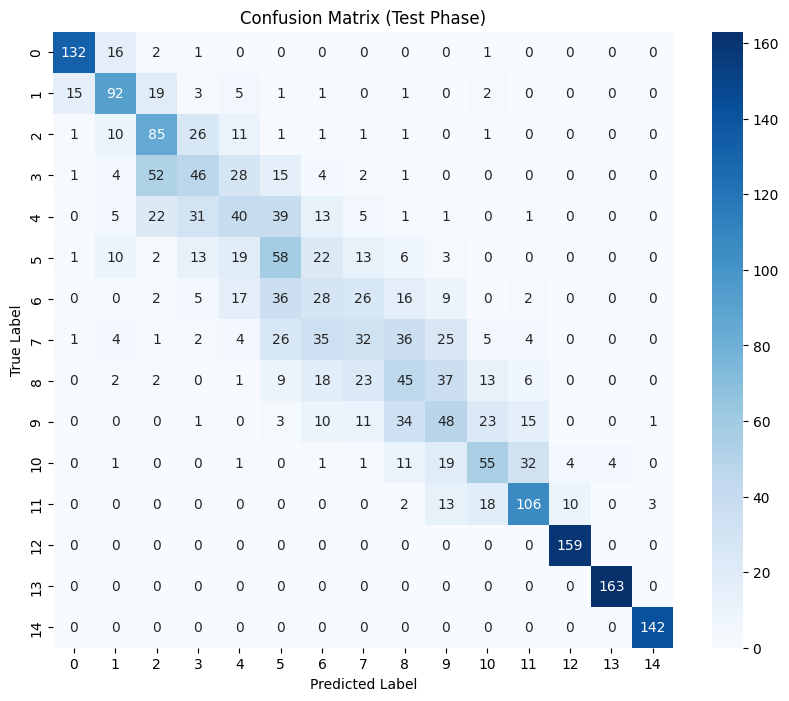

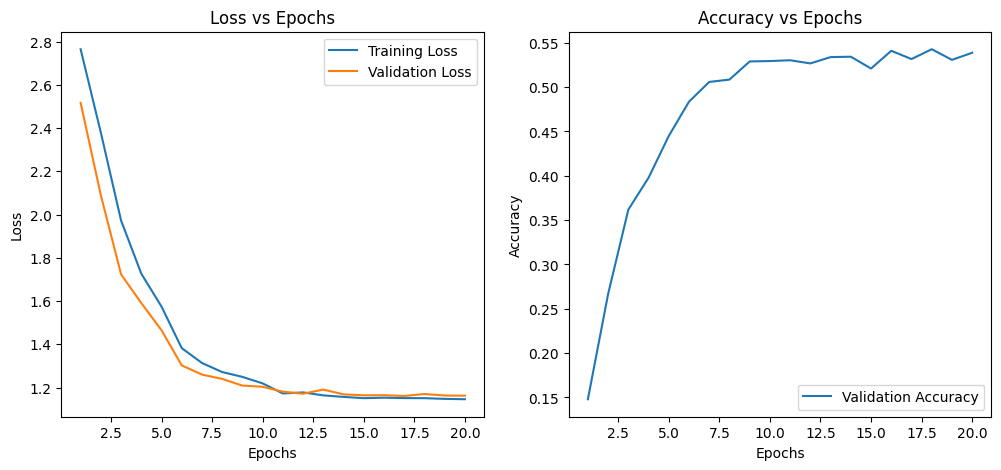

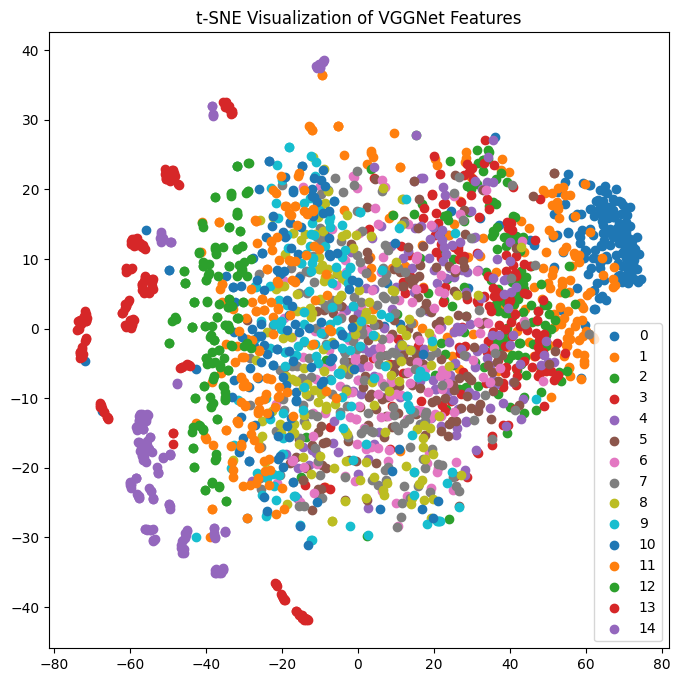

In [5]:
def train_model(model, train_loader, loss_fn, optimizer,device,epoch_metrics,scheduler):
    model.train()
    epoch_loss = 0
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    scheduler.step()
    epoch_metrics['train_loss'].append(epoch_loss / len(train_loader))

def test_model(dataloader, model, loss_fn,device,epoch_metrics,phase):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += loss_fn(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
            if phase=="test":
                all_preds.extend(pred.argmax(1).cpu().numpy())
                all_labels.extend(label.cpu().numpy())
    test_loss /= num_batches
    accuracy = correct / size
    print(f"Accuracy: {accuracy*100:.2f}%, Avg loss: {test_loss:.4f}")
    if phase == "valid":
        epoch_metrics[f'{phase}_loss'].append(test_loss)
        epoch_metrics[f'{phase}_accuracy'].append(accuracy)
    if phase == "test":
        cm = confusion_matrix(all_labels, all_preds)
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, digits=4))
        report = classification_report(all_labels, all_preds, output_dict=True)
        classes = list(range(15)) 
        plot_confusion_matrix(cm,classes,phase)
        epoch_metrics[f'{phase}_f1'] = report['weighted avg']['f1-score']
        epoch_metrics[f'{phase}_precision'] = report['weighted avg']['precision']
        epoch_metrics[f'{phase}_recall'] = report['weighted avg']['recall']


def model_vgg(train,test,valid):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.vgg19_bn()
    model.classifier[6] = nn.Linear(in_features=4096, out_features=15)
    feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
    model = model.to('cuda')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    epochs = 20
    epoch_metrics = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for t in range(epochs):
        print(f"=================== EPOCH {t+1} ====================")
        train_model(model, train, loss_fn, optimizer,device,epoch_metrics,scheduler)
        print("Validation:")
        test_model(valid, model, loss_fn,device,epoch_metrics,phase='valid')
    print("Final Test Evaluation:")
    test_model(test, model, loss_fn,device,epoch_metrics,phase='test')
    #saving model
    torch.save(model.state_dict(), 'vgg.pth')
    plot_metrics(epoch_metrics)
    features = []
    labels = []
    with torch.no_grad():
        for images, label in test:
            images = images.to(device)
            outputs = feature_extractor(images)
            features.append(outputs.view(outputs.size(0), -1).cpu())
            labels.append(label.cpu())
    
    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(8, 8))
    for label in set(labels):
        plt.scatter(
            reduced_features[labels == label, 0],
            reduced_features[labels == label, 1],
            label=str(label)
        )
    plt.legend()
    plt.title("t-SNE Visualization of VGGNet Features")
    plt.show()
    


def plot_metrics(epoch_metrics):
    epochs = range(1, len(epoch_metrics['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_metrics['train_loss'], label="Training Loss")
    plt.plot(epochs, epoch_metrics['valid_loss'], label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_metrics['valid_accuracy'], label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()
def plot_confusion_matrix(cm, classes, phase):
   
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({phase.capitalize()} Phase)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def main():
    df = load_data()
    df = resample_data(df)


    transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train,test,valid = split_data(df)

    train_dataset = UTKFaceDataset(train, transform=transform)
    test_dataset = UTKFaceDataset(test, transform=transform)
    valid_dataset = UTKFaceDataset(valid, transform=transform)

    train = data_loader(train_dataset)
    test = data_loader(test_dataset)
    valid = data_loader(valid_dataset)
    vgg = model_vgg(train,test,valid)
if __name__ == '__main__':
    main()
    